# Setup

In [13]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.optimizers import RMSprop, Adagrad, Adam, SGD

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from pprint import pprint

# Implementation

In [ ]:
# Reference architecture from
# https://blog.keras.io/building-autoencoders-in-keras.html

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#x_train = x_train[:len(x_test)]
#x_test = x_test[:7500]

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 100
latent_dim = 2
epochs = 50

In [3]:
print(len(x_train))
print(x_train.shape)
print(len(x_test))
print(x_test.shape)

60000
(60000, 784)
10000
(10000, 784)


Encoder network, mapping inputs to our latent distribution parameters.

In [4]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

Use these parameters to sample new similar points from the latent space.

In [5]:
def sampling(args):
    z_mean, z_log_sigma = args
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

Map these sampled latent points back to reconstructed inputs.

In [6]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

So far this allows us to instantiate 3 models:

- an end-to-end autoencoder mapping inputs to reconstructions
- an encoder mapping inputs to the latent space
- a generator that can take points on the latent space and will output the corresponding reconstructed samples.

In [7]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

Train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [8]:
def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

sgd = SGD()
vae.compile(optimizer=sgd, loss=vae_loss)

# Training

Train our VAE on MNIST digits.

In [9]:
vae_hist = vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 25s 415us/step - loss: 0.7102 - val_loss: 0.7023
Epoch 2/50
60000/60000 [==============================] - 15s 249us/step - loss: 0.6997 - val_loss: 0.6971
Epoch 3/50
60000/60000 [==============================] - 17s 288us/step - loss: 0.6952 - val_loss: 0.6933
Epoch 4/50
60000/60000 [==============================] - 15s 254us/step - loss: 0.6916 - val_loss: 0.6899
Epoch 5/50
60000/60000 [==============================] - 15s 251us/step - loss: 0.6884 - val_loss: 0.6868
Epoch 6/50
60000/60000 [==============================] - 17s 278us/step - loss: 0.6853 - val_loss: 0.6838
Epoch 7/50
60000/60000 [==============================] - 16s 272us/step - loss: 0.6822 - val_loss: 0.6807
Epoch 8/50
60000/60000 [==============================] - 16s 268us/step - loss: 0.6791 - val_loss: 0.6775
Epoch 9/50
60000/60000 [==============================] - 16s 264us/step - loss: 0.6760 - val_

In [11]:
# save model
vae.save("vae.h5")

In [17]:
# save history
vae_hist = vae_hist.history
with open('./runs/vae.hist', 'w', encoding="utf-8") as fout:
    pprint(vae_hist, fout)

In [18]:
def plotLoss(train, test):
    iterations = list(range(len(train)))
    plt.plot(iterations, train, label="train")
    plt.plot(iterations, test, label="test")       

    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='dotted')
    plt.legend() #loc="upper left"

    plt.show()

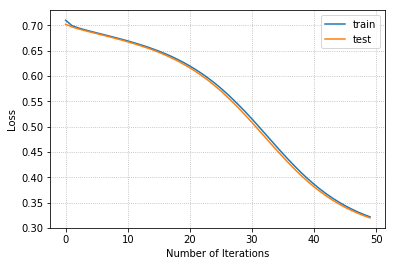

In [19]:
# show loss graph
plotLoss(vae_hist['loss'], vae_hist['val_loss'])

In [ ]:
# try to create a photo gallery
